## Notebook para EDA utilizando o dataset _auto-mpg_
> Este dataset é um dos conhecidos entre praticantes de DS/ML por ser simples simples para iniciantes, porém que nos permite entender as limitações de alguns algoritmos. O intuito deste notebook é entender um pouco da estrutura do dataset.
Disponível em: http://archive.ics.uci.edu/ml/datasets/Auto+MPG

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
from scipy import stats

In [2]:
df = pd.read_csv('auto-mpg.csv',index_col='car name')

In [3]:
print(df.head(),'\n\n',df.describe())
#horsepower is not appearing and is numerical

                            mpg  cylinders  displacement horsepower  weight  \
car name                                                                      
chevrolet chevelle malibu  18.0          8         307.0        130    3504   
buick skylark 320          15.0          8         350.0        165    3693   
plymouth satellite         18.0          8         318.0        150    3436   
amc rebel sst              16.0          8         304.0        150    3433   
ford torino                17.0          8         302.0        140    3449   

                           acceleration  model year  origin  
car name                                                     
chevrolet chevelle malibu          12.0          70       1  
buick skylark 320                  11.5          70       1  
plymouth satellite                 11.0          70       1  
amc rebel sst                      12.0          70       1  
ford torino                        10.5          70       1   

          

In [4]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
dtype: object

_horsepower_ se apresenta como do tipo _objeto_ quando deveria se apresentar como _int_. Vamos procurar por padrões que nao sejam numéricos.

In [5]:
df[~df['horsepower'].str.contains('[\d]+')]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
car name,,,,,,,,
ford pinto,25.0,4,98.0,?,2046,19.0,71,1
ford maverick,21.0,6,200.0,?,2875,17.0,74,1
renault lecar deluxe,40.9,4,85.0,?,1835,17.3,80,2
ford mustang cobra,23.6,4,140.0,?,2905,14.3,80,1
renault 18i,34.5,4,100.0,?,2320,15.8,81,2
amc concord dl,23.0,4,151.0,?,3035,20.5,82,1


Alguns kernels existentes optam por remover estes valores, neste notebook a título de exploração vamos testar a utilização de regressão linear como método para imputar valores.

Uma abordagem mais sensível para o caso de haverem mais dados que se assemelhassem a estes seria utilizar KNN regressores considerando que haveria maior quantidade de pontos dispersos próximos destas 6 observações

# A ideia agora é testar o knn regressor e comparar com a regressão para imputar valores: ler o artigo do analythics vidhya

O KNN talvez seja bem mais complexo para imputação pois variáveis categóricas como país deveriam para melhor serem alimentadas ao modelo serem One Hot Code Labeling(pd.get_dummy). Mesmo com one hot encoding a regressão linear parece ter melhor pontuação na validação cruzada então optamos por imputação via lin_reg

In [6]:
train = df[df['horsepower'] != '?']
train['horsepower'] = train['horsepower'].astype('float')

df_to_fill = df[df['horsepower'] == '?']
xz = df_to_fill[df_to_fill.columns.difference(['horsepower'])]
xz['origin'] = pd.get_dummies(xz['origin'])

C:\Users\Bronze\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Bronze\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
from sklearn.model_selection import train_test_split, KFold,  cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression


def KNN(pred):
    train['origin'] = pd.get_dummies(train['origin'])
    
    X = train[train.columns.difference(['horsepower'])]
                                       
    X_train,X_test,y_train,y_test = train_test_split(
        X,train['horsepower'],test_size = 0.2)

    scaler = MinMaxScaler(feature_range=(0, 1))

    #scalling all the DataFrames
    X_train = pd.DataFrame(scaler.fit_transform(X_train))
    X_test = pd.DataFrame(scaler.fit_transform(X_test))
    pred = pd.DataFrame(scaler.transform(pred))

    outer_cv = KFold(n_splits=5, shuffle=True)

    knn= KNeighborsRegressor(n_neighbors=3,weights='distance')
    knn.fit(X_train,y_train)
    
    nested_score = cross_val_score(knn, X=X_test, y=y_test, cv=outer_cv)
    print('Mean:',nested_score.mean(),'+/-',nested_score.std())

    y_pred = knn.predict(pred)
    return y_pred

KNN(xz)

Mean: 0.6426049354426734 +/- 0.14985505303270244


C:\Users\Bronze\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Bronze\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Bronze\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array([80.17532769, 93.4435469 , 60.45811015, 92.8277973 , 72.58412885,
       87.01749132])

In [8]:
def lin_reg(pred):
    X_train,X_test,y_train,y_test = train_test_split(
    train[train.columns.difference(['horsepower'])],train['horsepower'],test_size = 0.2,shuffle=True)

    outer_cv = KFold(n_splits=3, shuffle=True)

    reg = LinearRegression().fit(X_train,y_train)
    y_pred = reg.predict(pred)
    nested_score = cross_val_score(reg, X=X_test, y=y_test, cv=outer_cv)

    #print(r2_score(y_test,y_pred))
    print('Mean:',nested_score.mean(),'+/-',nested_score.std())
    return y_pred

lin_reg(xz)

Mean: 0.865929896215936 +/- 0.03880687359763401


array([59.05483176, 94.21238475, 59.44237064, 97.24166183, 78.53558519,
       73.64382633])

In [33]:
new_df = xz.copy()
new_df['horsepower'] = pd.Series((lin_reg(xz)),index = new_df.index)
new_df

Mean: 0.8835384333059393 +/- 0.002056032373602046


,acceleration,cylinders,displacement,model year,mpg,origin,weight,horsepower
car name,,,,,,,,
ford pinto,19.0,4,98.0,71,25.0,1,2046,59.629502
ford maverick,17.0,6,200.0,74,21.0,1,2875,94.291393
renault lecar deluxe,17.3,4,85.0,80,40.9,0,1835,60.725513
ford mustang cobra,14.3,4,140.0,80,23.6,1,2905,97.387266
renault 18i,15.8,4,100.0,81,34.5,0,2320,78.931246
amc concord dl,20.5,4,151.0,82,23.0,1,3035,75.676007


### criando a comparação para ambos os dataframes

In [38]:
df_inputed = pd.concat([new_df,train],sort=True)

#### proxima etapa EDA

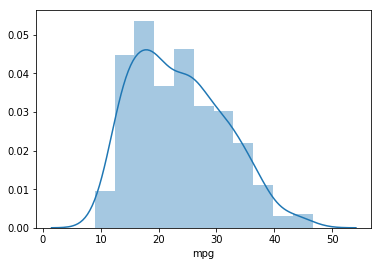

In [46]:
sns.distplot(df_inputed['mpg'],bins=11)

In [66]:
df_inputed.skew(axis=0)

acceleration    0.278777
cylinders       0.526922
displacement    0.719645
horsepower      1.102103
model year      0.011535
mpg             0.457066
origin         -0.521133
weight          0.531063
dtype: float64

In [72]:
features = df_inputed.columns.difference(['mpg'])
correlations = df_inputed[features].corr().abs().unstack().sort_values().reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations

,level_0,level_1,0
0,origin,model year,0.139883
1,model year,origin,0.139883
2,acceleration,origin,0.250806
3,origin,acceleration,0.250806
4,model year,acceleration,0.288137
5,acceleration,model year,0.288137
6,weight,model year,0.306564
7,model year,weight,0.306564
8,model year,cylinders,0.348746
9,cylinders,model year,0.348746


In [70]:
un_va = []

for feat in features:
    df_inputed[feat].value_counts()
    values = df_inputed[feat].value_counts()
    un_va.append([feat, values.max(), values.idxmax()])    

In [71]:
un_va

[['acceleration', 23, 14.5],
 ['cylinders', 204, 4],
 ['displacement', 21, 97.0],
 ['horsepower', 22, 150.0],
 ['model year', 40, 73],
 ['origin', 249, 1],
 ['weight', 4, 1985]]